In [ ]:
# Plot 100 for acf and pacf to see if there is seasonality involved
# Do timeseries decomposition and find strength of seasonality and strength of trend
# GPAC to see if there is a pattern 
# If you have seasonality then you do seansoanl differencing then do acf and pacf then feed that into the gpac. 
#then you will find order of NA and Np of SARIMA Model

#Recommendation:
    #do timeseries decomposition 
    # find trend seasonality 
    #then do autucorrelation for longer 100 then if you spot seasnoalit you do seasonal differencing then u put 
    #in the d parameter

    # before feeding to gpac you have to make data sattionary and plot rolling mean and rolling variance make sure its 
    #stationary then estimate the autocorrelation then feed autucorrelation into gpac and see if u can see a pattern

    #check lab 6, 7, 8, 9, 10
    
#plot rolling mean and variance of stationarity dataset   
#Plot ACF and pacf of stationart data set
# calculate autucorrolation of stationary data set
#feed it to the GPAC, read the pattern, estimate the coeffecient, develop forecast function then do prediction

In [1]:
import pandas_datareader as web

In [2]:
!pip install pandas_datareader

In [2]:
arima = web.DataReader('AAPL', data_source='yahoo', start='2002-01-01', end ='2021-09-29')
arima

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,0.416071,0.392143,0.393750,0.416071,529496800.0,0.356725
2002-01-03,0.424107,0.406607,0.410714,0.421071,612007200.0,0.361012
2002-01-04,0.427679,0.410536,0.416786,0.423036,409976000.0,0.362696
2002-01-07,0.428571,0.406250,0.423571,0.408929,444584000.0,0.350602
2002-01-08,0.411607,0.401071,0.406250,0.403750,450038400.0,0.346161
...,...,...,...,...,...,...
2021-09-23,147.080002,145.639999,146.649994,146.830002,64838200.0,146.616028
2021-09-24,147.470001,145.559998,145.660004,146.919998,53477900.0,146.705887
2021-09-27,145.960007,143.820007,145.470001,145.369995,74150700.0,145.158142


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import math
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
import datetime as dt

In [4]:
arima = arima[["Close"]].copy()
arima

,Close
Date,
2002-01-02,0.416071
2002-01-03,0.421071
2002-01-04,0.423036
2002-01-07,0.408929
2002-01-08,0.403750
...,...
2021-09-23,146.830002
2021-09-24,146.919998
2021-09-27,145.369995


# Stock Price Visualization:

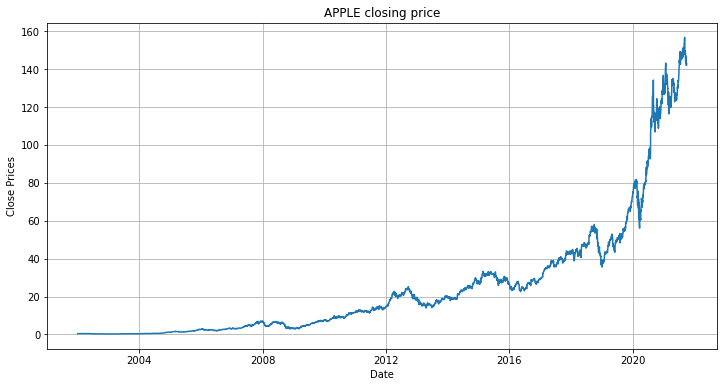

In [5]:
#plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(arima)
plt.title('APPLE closing price')
plt.show()

# Dataset Probability Distribution:

<AxesSubplot:ylabel='Density'>

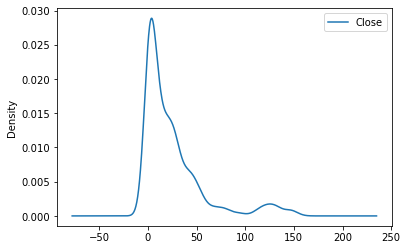

In [7]:
#Distribution of the dataset
APPLE = arima
APPLE.plot(kind='kde')

In [ ]:
# A time series is also regarded to include three systematic components: 
#level, trend, and seasonality, as well as one non-systematic component termed noise.

#1) The average value in the series is called the level.
#2)The increasing or falling value in the series is referred to as the trend.
#3)Seasonality is the series’ recurring short-term cycle.
#4)The random variance in the series is referred to as noise.

# Autocorrelation & Partial Autocorrelation

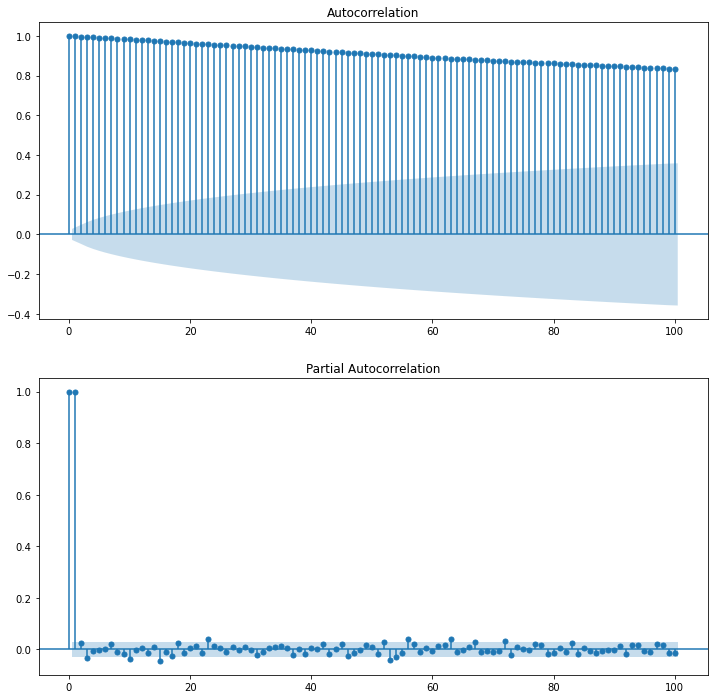

In [6]:
lags = 100

plt.figure(figsize=(12,12))
plt.subplot(211)
plot_acf(arima, ax=plt.gca(), lags = lags)

plt.subplot(212)
plot_pacf(arima, ax=plt.gca(), lags = lags)
plt.show()


# Rolling Statistics Test for staionarity:

In [8]:
Rolling = arima.reset_index()
for i in range(0, arima.shape[0]):
    n = i+1
    mean = sum(arima.head(n)['Close']/n)
    num = (arima['Close'][i] - mean)**2
    arima.loc[arima.index[i], 'Rolling Mean'] = mean
    arima.loc[arima.index[i], 'Rolling Variance'] = num/(n-1)

In [9]:
Rolling

,Date,Close,Rolling Mean,Rolling Variance
0,2002-01-02,0.416071,0.416071,NaN
1,2002-01-03,0.421071,0.418571,0.000006
2,2002-01-04,0.423036,0.420059,0.000004
3,2002-01-07,0.408929,0.417277,0.000023
4,2002-01-08,0.403750,0.414571,0.000029
...,...,...,...,...
4966,2021-09-23,146.830002,24.836886,2.996843
4967,2021-09-24,146.919998,24.861460,2.999454
4968,2021-09-27,145.369995,24.885712,2.921993
4969,2021-09-28,141.910004,24.909258,2.754915


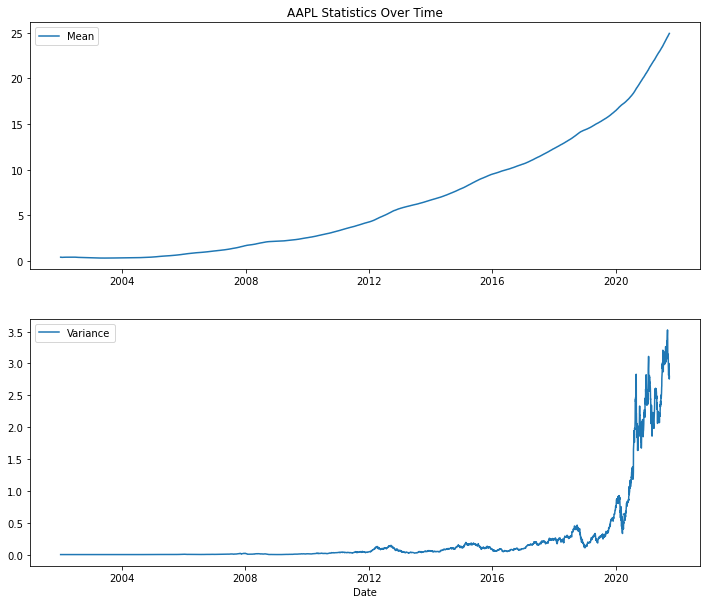

In [10]:
plt.figure(figsize = (12,10))
plt.subplot(211)
plt.title('AAPL Statistics Over Time')
plt.plot(Rolling.Date, Rolling['Rolling Mean'], label='Mean')
plt.legend()
plt.subplot(212)
plt.plot(Rolling.Date, Rolling['Rolling Variance'], label='Variance')
plt.legend()
plt.xlabel('Date')
plt.show()

In [11]:
arima

,Close,Rolling Mean,Rolling Variance
Date,,,
2002-01-02,0.416071,0.416071,NaN
2002-01-03,0.421071,0.418571,0.000006
2002-01-04,0.423036,0.420059,0.000004
2002-01-07,0.408929,0.417277,0.000023
2002-01-08,0.403750,0.414571,0.000029
...,...,...,...
2021-09-23,146.830002,24.836886,2.996843
2021-09-24,146.919998,24.861460,2.999454
2021-09-27,145.369995,24.885712,2.921993


In [12]:
arima = arima[['Close']].copy()
arima

,Close
Date,
2002-01-02,0.416071
2002-01-03,0.421071
2002-01-04,0.423036
2002-01-07,0.408929
2002-01-08,0.403750
...,...
2021-09-23,146.830002
2021-09-24,146.919998
2021-09-27,145.369995


# ADF (Augmented Dickey-Fuller) Test for staionarity:

1) ADF test


In [13]:
# ADF test on AAPL

result = adfuller(arima['Close'])
print('AAPLE')
print("ADF Statistic: %f" %result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

AAPLE
ADF Statistic: 3.149904
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:

# Since the p-value is bigger than 0.05, the series non-stationary.
# the test statistics exceed the critical values. As a result, the data is nonlinear.

# Seasonality & Trend Strength:

In [14]:
from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [15]:
data = arima['Close']
data = data.resample('M').mean().ffill()
data

Date
2002-01-31      0.403691
2002-02-28      0.425320
2002-03-31      0.432902
2002-04-30      0.438563
2002-05-31      0.430633
                 ...    
2021-05-31    126.784000
2021-06-30    129.958636
2021-07-31    145.139524
2021-08-31    148.177727
2021-09-30    148.646500
Freq: M, Name: Close, Length: 237, dtype: float64

In [16]:
stl = STL(data)
res = stl.fit()

t = res.trend
s = res.seasonal
r = res.resid

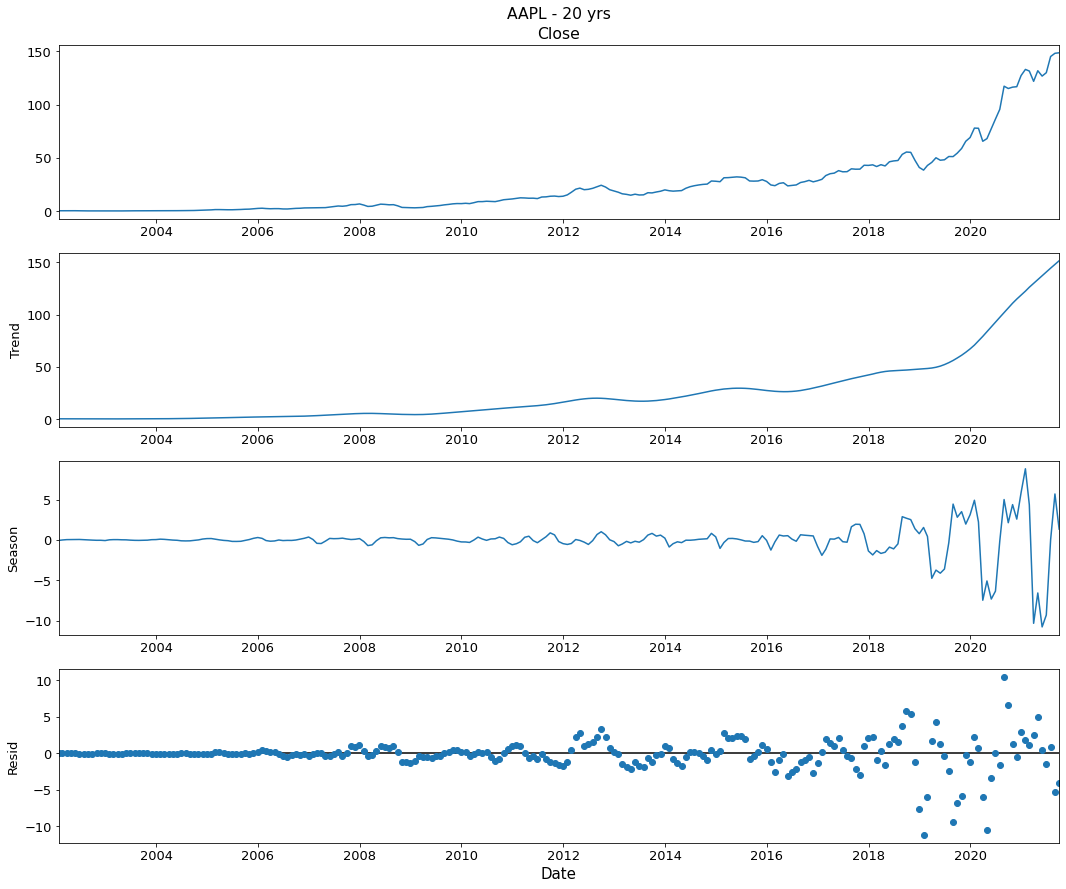

In [17]:
plt.rc('figure', figsize = (15,12))
plt.rc('font', size = 13)

res.plot()
plt.title('AAPL - 20 yrs', pad = 650)
plt.xlabel('Date', fontsize =15)
plt.show()

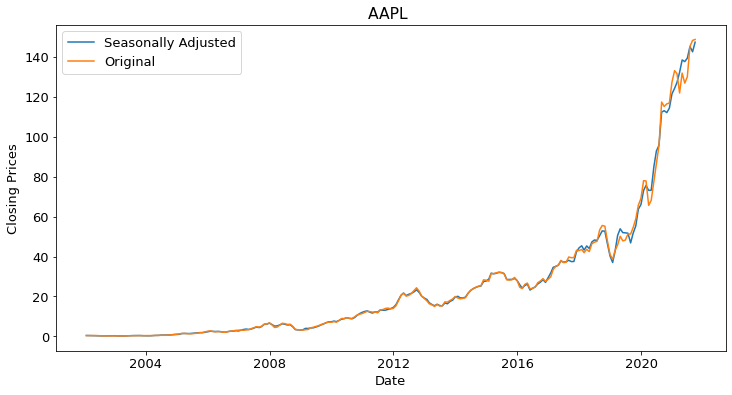

In [18]:
# Seasonally adjusted data
adjusted_seasonal = data - s

plt.figure(figsize=(12,6))
plt.plot(adjusted_seasonal, label='Seasonally Adjusted')
plt.plot(data, label='Original')
plt.title('AAPL ')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

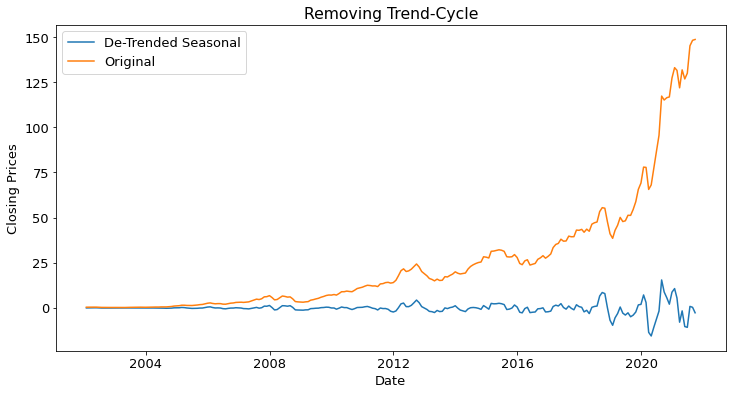

In [19]:
# Detrended data
detrended = data - t

plt.figure(figsize=(12,6))
plt.plot(detrended, label='De-Trended Seasonal')
plt.plot(data, label='Original')
plt.title('Removing Trend-Cycle')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

In [20]:
# Strength of trend & seasonality
r = np.array(r)
s = np.array(s)
t = np.array(t)
Ft = np.max([0,1-np.var(r)/np.var(t+r)])
Fs = np.max([0,1-np.var(r)/np.var(s+r)])
print('The strength of the trend for this dataset is = ', Ft)
print('The strength of the seasonality for this dataset is = ', Fs)

The strength of the trend for this dataset is =  0.9954832517313532
The strength of the seasonality for this dataset is =  0.4863323445102017


In [ ]:
# To reduce of the growing trend in the series, we first take a log of the series. 
# We then calculate the rolling average of the series after obtaining the log of the series.
#A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

# Make Data Stationary

In [21]:
# First order differencing of the closing price
df_log1 = arima['Close'].diff()
df_log1

Date
2002-01-02         NaN
2002-01-03    0.005000
2002-01-04    0.001965
2002-01-07   -0.014107
2002-01-08   -0.005179
                ...   
2021-09-23    0.979996
2021-09-24    0.089996
2021-09-27   -1.550003
2021-09-28   -3.459991
2021-09-29    0.919998
Name: Close, Length: 4971, dtype: float64

In [23]:
df_log = pd.DataFrame(data=df_log1)
df_log

,Close
Date,
2002-01-02,NaN
2002-01-03,0.005000
2002-01-04,0.001965
2002-01-07,-0.014107
2002-01-08,-0.005179
...,...
2021-09-23,0.979996
2021-09-24,0.089996
2021-09-27,-1.550003


In [26]:
# ADF test First order differencing 
result = adfuller(df_log[1:])
print('AAPL First order differencing')
print("ADF Statistic: %f" %result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

AAPL First order differencing
ADF Statistic: -12.228920
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [44]:
df_log.to_csv('log_prices.csv')

# Plotting Rolling Mean and Standard Deviation After Differencing 

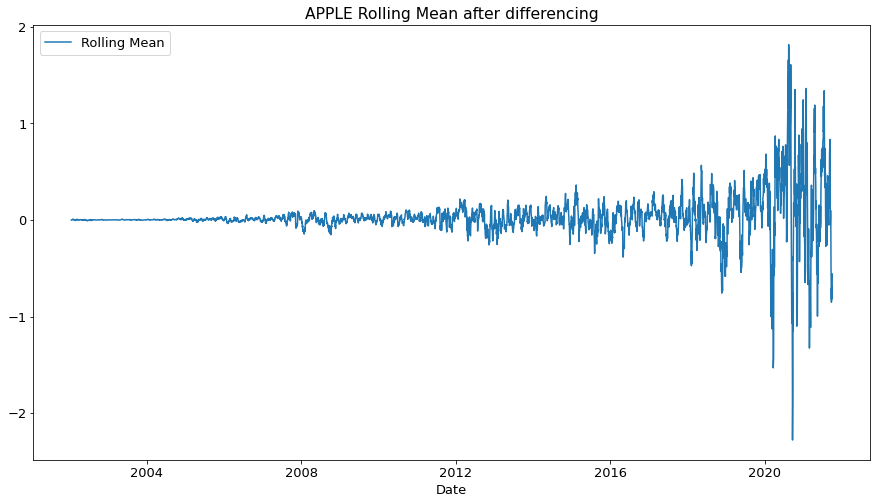

In [27]:
# Plotting mean 

rolling_mean = df_log.rolling(window = 12).mean()

plt.figure(figsize=(15,8))
plt.plot(rolling_mean, label = 'Rolling Mean')
plt.legend()
plt.title('APPLE Rolling Mean after differencing')
plt.xlabel('Date')
plt.show()

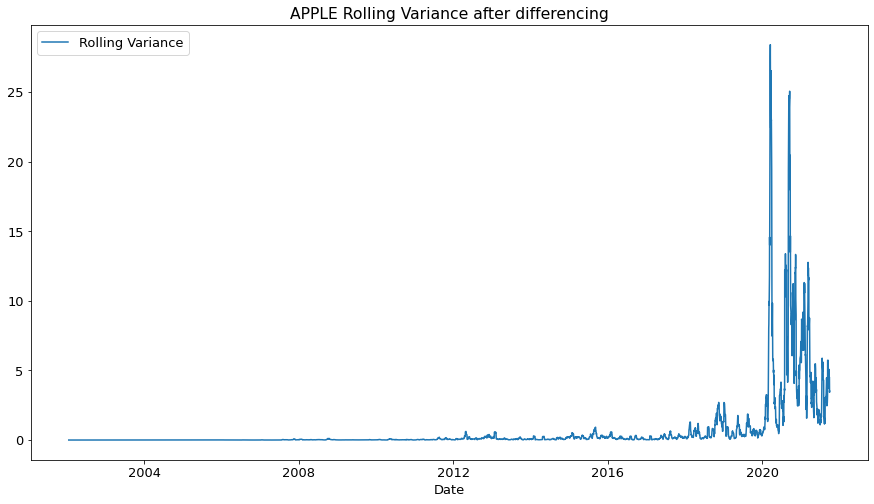

In [28]:
# plotting variance

rolling_var = df_log.rolling(window = 12).var()

plt.figure(figsize=(15,8))
plt.plot(rolling_var, label = 'Rolling Variance')
plt.legend()
plt.title('APPLE Rolling Variance after differencing')
plt.xlabel('Date')
plt.show()

In [45]:
rolling_var.to_csv('rolling_var.csv')

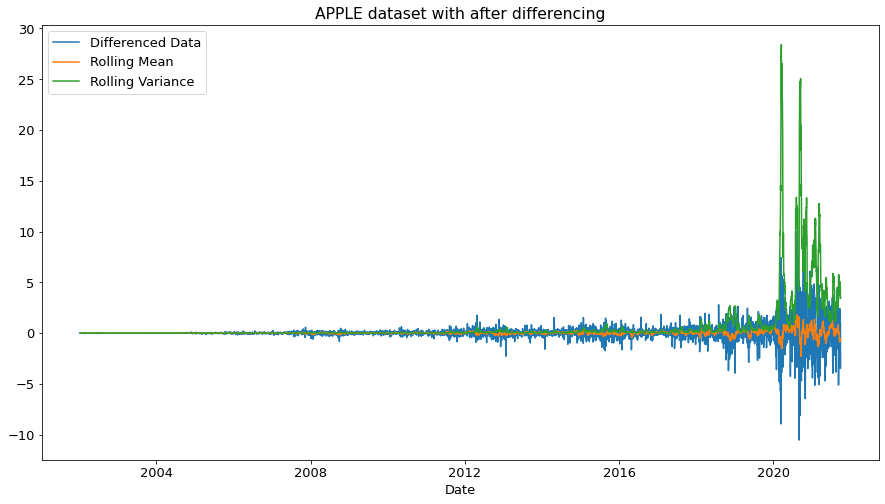

In [29]:
# plotting mean and variance together 

rolling_mean = df_log.rolling(window = 12).mean()
rolling_var = df_log.rolling(window = 12).var()


plt.figure(figsize=(15,8))
plt.plot(df_log.index.values, df_log, label = 'Differenced Data')
plt.plot(rolling_mean, label = 'Rolling Mean')
plt.plot(rolling_var, label = 'Rolling Variance')
plt.legend()
plt.title('APPLE dataset with after differencing')
plt.xlabel('Date')
plt.show()

# Plotting APPLE Stock Price After Differencing

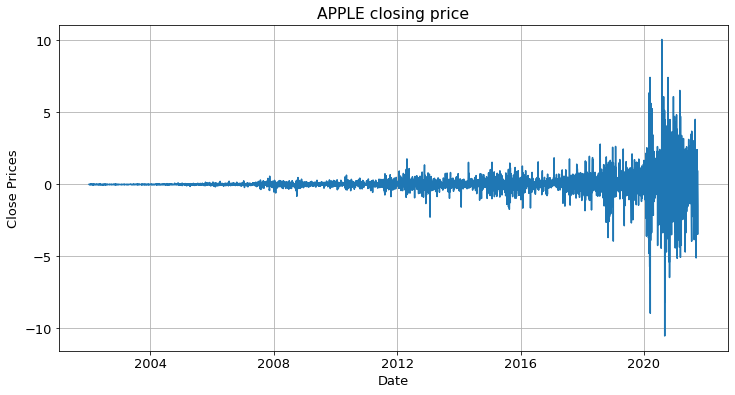

In [30]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_log)
plt.title('APPLE closing price')
plt.show()

# Autocorrelation & Partial Autocorrelation After Differencing (After Reaching Stationarity) (found HW4 $ HW 9)

In [11]:
def autocorr_cal(y, lags):
    
    ry = [1]
    mean = np.mean(y)

    for i in range(1, lags+1):
        sum_auto = 0
        for j in range(i, len(y)):
            sum_auto += (y[j]-mean)*(y[j-i]-mean)

        auto_cov = sum_auto/len(y)

        
        ry.append(auto_cov/np.var(y))
    return ry

            

In [12]:
df_log

NameError: name 'df_log' is not defined

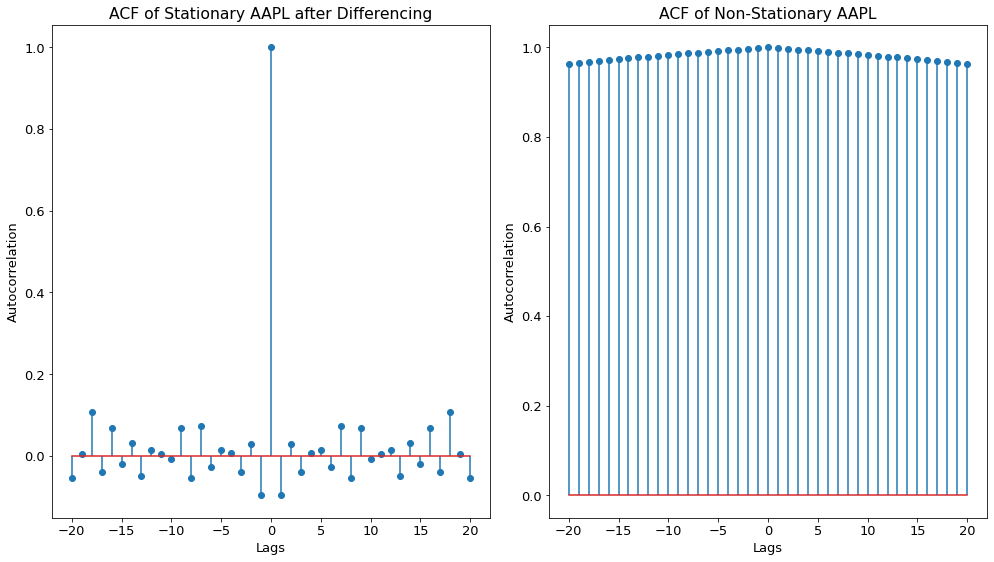

In [33]:
#def auocorr_cal(y, lags):

tau = 20
ry = autocorr_cal(df_log['Close'][1:], tau)
x = np.linspace(-20,20,41)

# Create reverse of ry, ryy
ryy = ry[::-1]
Ry = ryy + ry[1::]

# Plot autocorrelation
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(1,2,1)
ax1.stem(x, Ry, use_line_collection = True)
ax1.set(xlabel = 'Lags', ylabel = 'Autocorrelation')
ax1.set_title('ACF of Stationary AAPL after Differencing')

# Find autocorrelation of APPLE at 20 lags
tau = 20
ry = autocorr_cal(arima['Close'], tau)

# Create reverse of ry, ryy
ryy = ry[::-1]
Ry = ryy + ry[1::]

# Plot 
ax2 = fig.add_subplot(1,2,2)
ax2.stem(x, Ry, use_line_collection = True)
ax2.set(xlabel = 'Lags', ylabel = 'Autocorrelation')
ax2.set_title('ACF of Non-Stationary AAPL')

fig.tight_layout()
plt.show()
    

In [34]:
Ry

[0.9636831410865792,
 0.9656725958497283,
 0.9676846171056166,
 0.9696456847693713,
 0.9716835367850415,
 0.9736430454699366,
 0.9755894611160139,
 0.9774008155549918,
 0.9792544183796039,
 0.9810662352867437,
 0.9828954226728169,
 0.9847225843946998,
 0.9864454432741211,
 0.988129687019091,
 0.9897798056754425,
 0.9915004515467037,
 0.9932331606321988,
 0.9949625664647764,
 0.9966797541931353,
 0.998300470777456,
 1,
 0.998300470777456,
 0.9966797541931353,
 0.9949625664647764,
 0.9932331606321988,
 0.9915004515467037,
 0.9897798056754425,
 0.988129687019091,
 0.9864454432741211,
 0.9847225843946998,
 0.9828954226728169,
 0.9810662352867437,
 0.9792544183796039,
 0.9774008155549918,
 0.9755894611160139,
 0.9736430454699366,
 0.9716835367850415,
 0.9696456847693713,
 0.9676846171056166,
 0.9656725958497283,
 0.9636831410865792]

In [35]:
def GPAC_cal(Ry, k, j): # RY is the estimated autocorrelation
    
    for c in range(1, k):
        
        if c == 1:
            phi_col = []
            for i in range(j):
                start = len(Ry)//2 + i + 1
                num = Ry[start]
                den = Ry[start-1]
                phi_col.append((num/den).tolist())
                matrix1 = np.array(phi_col)

        elif c == 2:
            phi_col = []
            for i in range(j):  
                start = len(Ry)//2 + i
                l_col = Ry[start:start+c] 
                r_num = Ry[start+1:start+c+1]  
                num = np.column_stack((l_col,r_num))
                r_den = Ry[start-1:start+c-1]
                den = np.column_stack((l_col,r_den))
                phi_col.append(np.linalg.det(num)/np.linalg.det(den))
            matrix2 = np.array(phi_col).reshape(j,1)
            matrix = np.column_stack((matrix1,matrix2))
        else:
            phi_col = []
            for i in range(j):
                col = []
                for a in range(c-1): 
                    start = len(Ry)//2 + i
                    col.append(Ry[start-a:start+c-a].tolist())
                col = np.array(col).T
                r_num = Ry[start+1:start+c+1]
                r_den = Ry[start-c+1:start+1]
                num = np.column_stack((col,r_num))
                den = np.column_stack((col,r_den))
                phi_col.append(np.linalg.det(num)/np.linalg.det(den))
            matrix3 = np.array(phi_col)
            matrix = np.column_stack((matrix,matrix3))
    plt.figure(figsize=(12,8))
    sns.heatmap(matrix, annot=True, annot_kws={'size':15}, fmt='.3f', xticklabels=np.arange(1, k, step=1))
    sns.color_palette('rocket')
    plt.show()

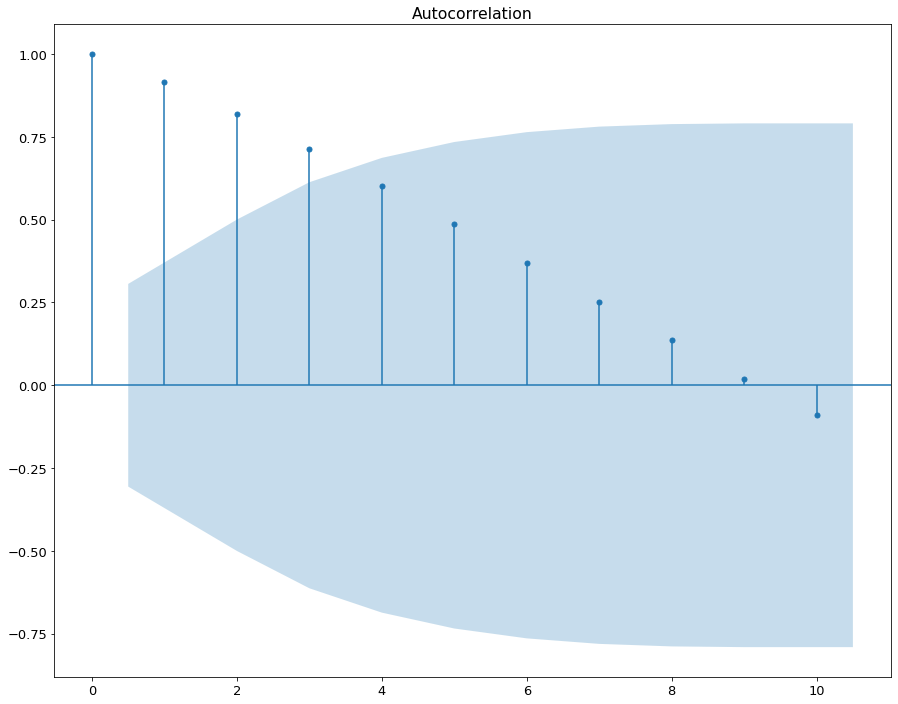

In [36]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(Ry, lags=10)
plt.show()


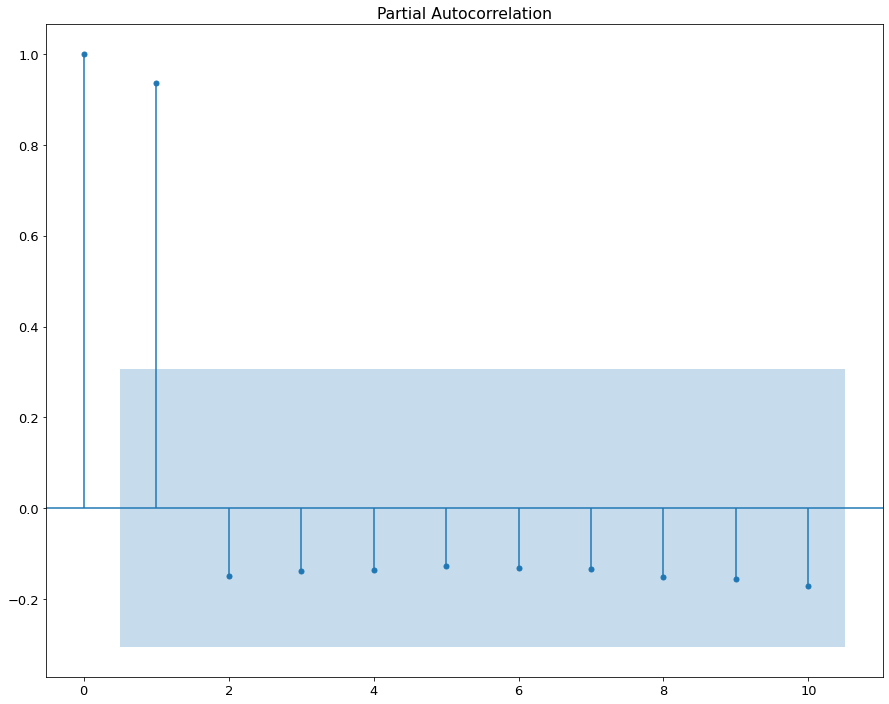

In [37]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_pacf(Ry, lags=10)
plt.show()

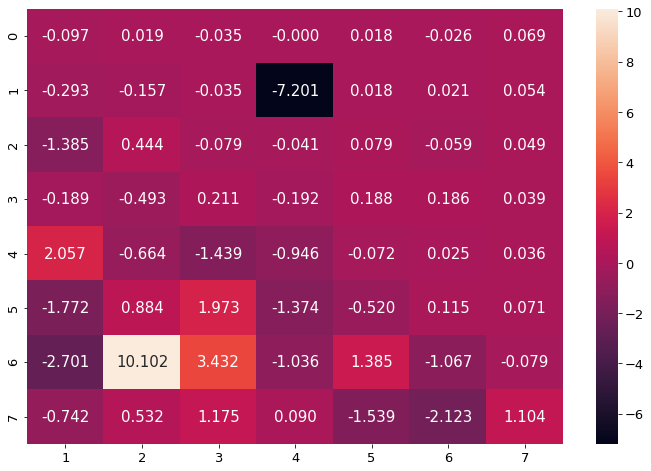

In [38]:
# Plot ACF & PACF
lags = 100

# GPAC
ry = sm.tsa.stattools.acf(df_log[1:], nlags=lags)
ry1 = ry[::-1]
Ry = np.concatenate((ry1[0:-1], ry))
GPAC_cal(Ry,8,8)

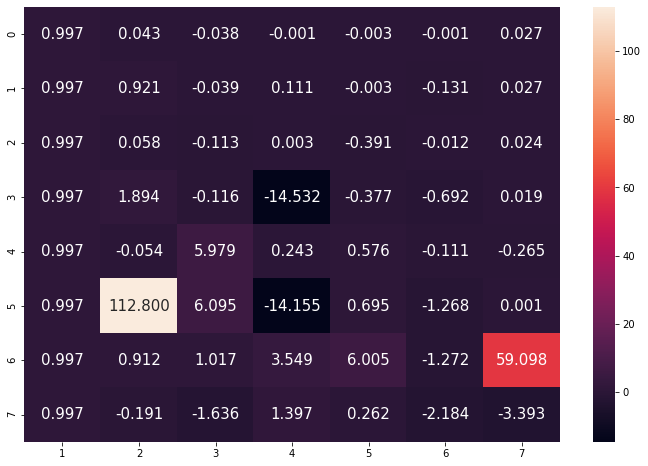

In [46]:
# #Plot ACF & PACF
#lags = 100

#GPAC
#ry = sm.tsa.stattools.acf(arima, nlags=lags)
#ry1 = ry[::-1]
#Ry = np.concatenate((ry1[0:-1], ry))
#GPAC_cal(Ry,8,8)

# Splitting data into training and testing

In [39]:
arima['Close']

Date
2002-01-02      0.416071
2002-01-03      0.421071
2002-01-04      0.423036
2002-01-07      0.408929
2002-01-08      0.403750
                 ...    
2021-09-23    146.830002
2021-09-24    146.919998
2021-09-27    145.369995
2021-09-28    141.910004
2021-09-29    142.830002
Name: Close, Length: 4971, dtype: float64

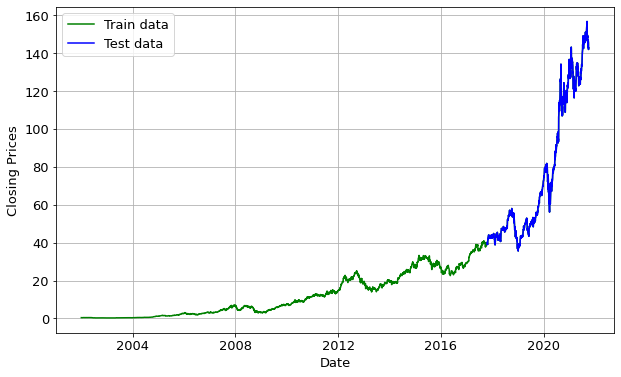

In [40]:
#split data into train and training set
train_data, test_data = arima['Close'][0:int(len(arima['Close'])*0.80)], arima['Close'][int(len(arima['Close'])*0.80):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.plot(arima['Close'], 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [41]:
print(len(train_data))
print(len(test_data))

3976
995


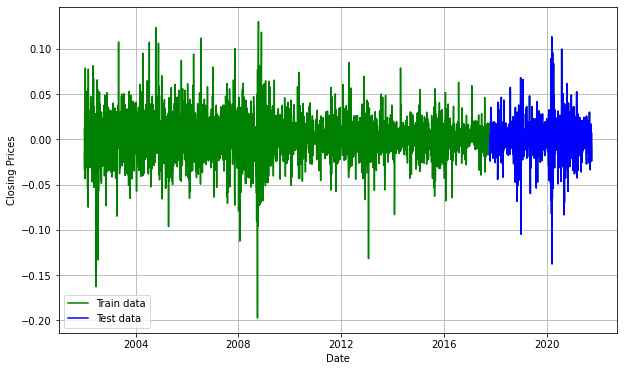

In [38]:
#split data into train and training set
train_data, test_data = df_log1[0:int(len(df_log1)*0.8)], df_log1[int(len(df_log1)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.plot(df_log1, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Naive Model

In [6]:
# the last period value is the forecat for this period

naive = arima
naive

,Close
Date,
2002-01-02,0.416071
2002-01-03,0.421071
2002-01-04,0.423036
2002-01-07,0.408929
2002-01-08,0.403750
...,...
2021-09-23,146.830002
2021-09-24,146.919998
2021-09-27,145.369995


In [7]:
naive ['lag'] = arima['Close'].shift(1)
naive

,Close,lag
Date,,
2002-01-02,0.416071,NaN
2002-01-03,0.421071,0.416071
2002-01-04,0.423036,0.421071
2002-01-07,0.408929,0.423036
2002-01-08,0.403750,0.408929
...,...,...
2021-09-23,146.830002,145.850006
2021-09-24,146.919998,146.830002
2021-09-27,145.369995,146.919998


In [8]:
# splitting data into 80 training 20 test

train, test = naive[1:naive.shape[0]-995], naive[naive.shape[0]-995:]

In [9]:
train_x, train_y = train['lag'], train['Close']
test_x, test_y = test['lag'], test['Close']

In [10]:
forecast = test_x.copy()


In [11]:
print(forecast)
print(test_y)

# the first are the forecasted values and the second are the actual values
# as we see the value of 2020-12-30 is the predicted values for price 2020-12-31

Date
2017-10-17     39.970001
2017-10-18     40.117500
2017-10-19     39.939999
2017-10-20     38.994999
2017-10-23     39.062500
                 ...    
2021-09-23    145.850006
2021-09-24    146.830002
2021-09-27    146.919998
2021-09-28    145.369995
2021-09-29    141.910004
Name: lag, Length: 995, dtype: float64
Date
2017-10-17     40.117500
2017-10-18     39.939999
2017-10-19     38.994999
2017-10-20     39.062500
2017-10-23     39.042500
                 ...    
2021-09-23    146.830002
2021-09-24    146.919998
2021-09-27    145.369995
2021-09-28    141.910004
2021-09-29    142.830002
Name: Close, Length: 995, dtype: float64


In [12]:
mse = mean_squared_error(test_y, forecast)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_y, forecast)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_y, forecast))
print('RMSE: '+str(rmse))

MSE: 2.9348120675008946
MAE: 1.1079244489046796
RMSE: 1.7131293201334494


In [13]:
def train_MSE(error_sq):
    
    return sum(error_sq.fillna(0))/(len(error_sq) - 1)

In [14]:
def test_MSE(error_sq):

    return sum(error_sq)/(len(error_sq))  

# Alternatively for MSE: mse = np.square(np.subtract(y_test,prediction)).mean()

In [15]:
def variance(error_sq):

    return sum(error_sq.fillna(0))/(len(arima['Close']) - 1)

In [16]:
# Copy training dataframe
naive = arima.copy(deep = True)

# Generate close(t-1)
for i in range(0, naive.shape[0]-1):
     naive.loc[naive.index[i+1], 'naive'] = naive['Close'][i]

# Generate error term
for i in range(1, naive.shape[0]):
    naive.loc[naive.index[i], 'naive_e'] = naive['Close'][i] - naive['naive'][i]

# Generate squared error
for i in range(1, naive.shape[0]):
    naive.loc[naive.index[i], 'naive_e^2'] = naive['naive_e'][i]**2

# split data to train and test
train = naive[:3976]
test = naive[3976:]

# Get MSE for naive train and test sets
naive_train_MSE = train_MSE(train['naive_e^2'])
naive_test_MSE = test_MSE(test['naive_e^2'])
naive

,Close,lag,naive,naive_e,naive_e^2
Date,,,,,
2002-01-02,0.416071,NaN,NaN,NaN,NaN
2002-01-03,0.421071,0.416071,0.416071,0.005000,0.000025
2002-01-04,0.423036,0.421071,0.421071,0.001965,0.000004
2002-01-07,0.408929,0.423036,0.423036,-0.014107,0.000199
2002-01-08,0.403750,0.408929,0.408929,-0.005179,0.000027
...,...,...,...,...,...
2021-09-23,146.830002,145.850006,145.850006,0.979996,0.960392
2021-09-24,146.919998,146.830002,146.830002,0.089996,0.008099
2021-09-27,145.369995,146.919998,146.919998,-1.550003,2.402509


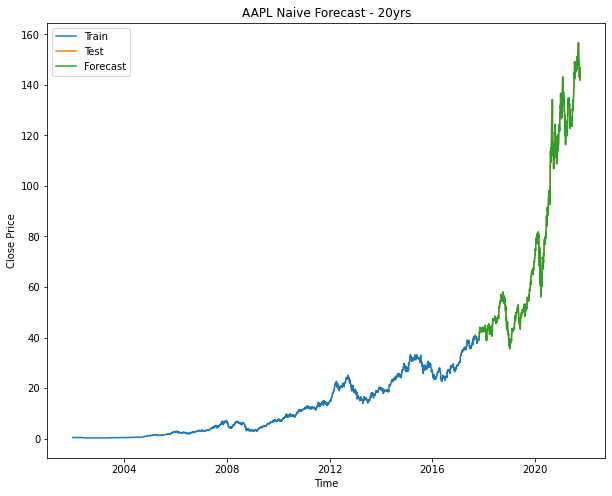

In [17]:
plt.figure(figsize = (10,8))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, test['naive'], label='Forecast')
plt.title('AAPL Naive Forecast - 20yrs')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.show()

In [54]:
# Print MSE results
print('MSE of prediction errors: ', naive_train_MSE)
print('MSE of forecast errors: ', naive_test_MSE)

MSE of prediction errors:  0.061544373293684326
MSE of forecast errors:  2.9348120675008946


# ARIMA Model

In [ ]:
# Auto ARIMA: Automatically discover the optimal order for an ARIMA model. 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=195.874, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=197.111, Time=0.99 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=197.070, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=200.274, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=199.862, Time=0.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.271 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3976
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -95.937
Date:                Sat, 20 Nov 2021   AIC                            195.874
Time:                        21:35:30   BIC                            208.449
Sample:                             0   HQIC                           200.333
                               - 3976                                         
Co

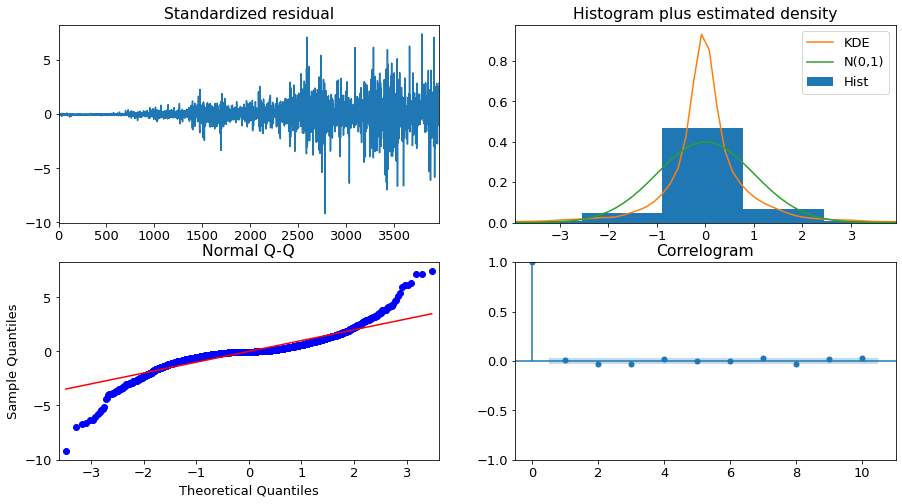

In [55]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

#Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

#Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

#Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

# Modeling:


In [56]:
# Build Model
# if differencing is involved then train data must be raw data that is non stationary
# develop forecasting function after building the model

#  fit a model using training data, and then to evaluate its performance on a test data set.
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit() 
print(fitted.summary())



#from statsmodels.tsa.arima_model import ARMA
#from statsmodels.tsa.arima.model import ARIMA

#model = ARMA(train_data, order=(1, 1))# fit model
#fitted = model.fit(disp=-1)  
#print(fitted.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3975
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -95.937
Method:                           css   S.D. of innovations              0.248
Date:                Sat, 20 Nov 2021   AIC                            195.874
Time:                        21:35:35   BIC                            208.449
Sample:                             1   HQIC                           200.333
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.004      2.531      0.011       0.002       0.018


# Forecasting

In [69]:
# ARIMA Walk Forward

data = train_data
predict = []
for t in test_data:
    model = ARIMA(data, order=(1,1,0))
    model_fit = model.fit()
    y = model_fit.forecast()
    print(y[0][0])
    predict.append(y[0][0])
    data = np.append(data,t)
    data = pd.Series(data)

39.9898304086468
40.12944321380892
39.947288303071
38.99051001218995
39.07305512116357
39.05177176423759
39.28800250501035
39.10959647753003
39.365686939671825
40.794415831915465
41.70902130430381
42.28336166205633
41.721187652382476
42.0440114664557
43.159518869659195
43.58340990352314
43.71642763174855
44.079266575741855
43.97849793888387
43.67080348223381
43.49877956129166
42.82909053002256
42.26538264010382
42.79798304039528
42.54194429487977
42.50421500878888
43.314746863970846
43.76225902230334
43.75310979701934
43.527331873754875
43.27130712135687
42.35605092616669
42.987504985075724
42.767969215723625
42.4525821727082
42.4192342978952
42.25880506230918
42.34209248985255
42.35299661971813
43.19811539022397
42.929602952333695
43.08122140765989
43.065071853609865
43.51323062752161
44.1305767924081
43.63455916659527
43.596877366665204
43.766871335648226
43.76301954133097
42.6268119223623
42.66042475053396
42.78306758223716
42.30699516476194
43.09177016647161
43.067692504238444
43.2

In [70]:
predict

[39.9898304086468,
 40.12944321380892,
 39.947288303071,
 38.99051001218995,
 39.07305512116357,
 39.05177176423759,
 39.28800250501035,
 39.10959647753003,
 39.365686939671825,
 40.794415831915465,
 41.70902130430381,
 42.28336166205633,
 41.721187652382476,
 42.0440114664557,
 43.159518869659195,
 43.58340990352314,
 43.71642763174855,
 44.079266575741855,
 43.97849793888387,
 43.67080348223381,
 43.49877956129166,
 42.82909053002256,
 42.26538264010382,
 42.79798304039528,
 42.54194429487977,
 42.50421500878888,
 43.314746863970846,
 43.76225902230334,
 43.75310979701934,
 43.527331873754875,
 43.27130712135687,
 42.35605092616669,
 42.987504985075724,
 42.767969215723625,
 42.4525821727082,
 42.4192342978952,
 42.25880506230918,
 42.34209248985255,
 42.35299661971813,
 43.19811539022397,
 42.929602952333695,
 43.08122140765989,
 43.065071853609865,
 43.51323062752161,
 44.1305767924081,
 43.63455916659527,
 43.596877366665204,
 43.766871335648226,
 43.76301954133097,
 42.6268119223

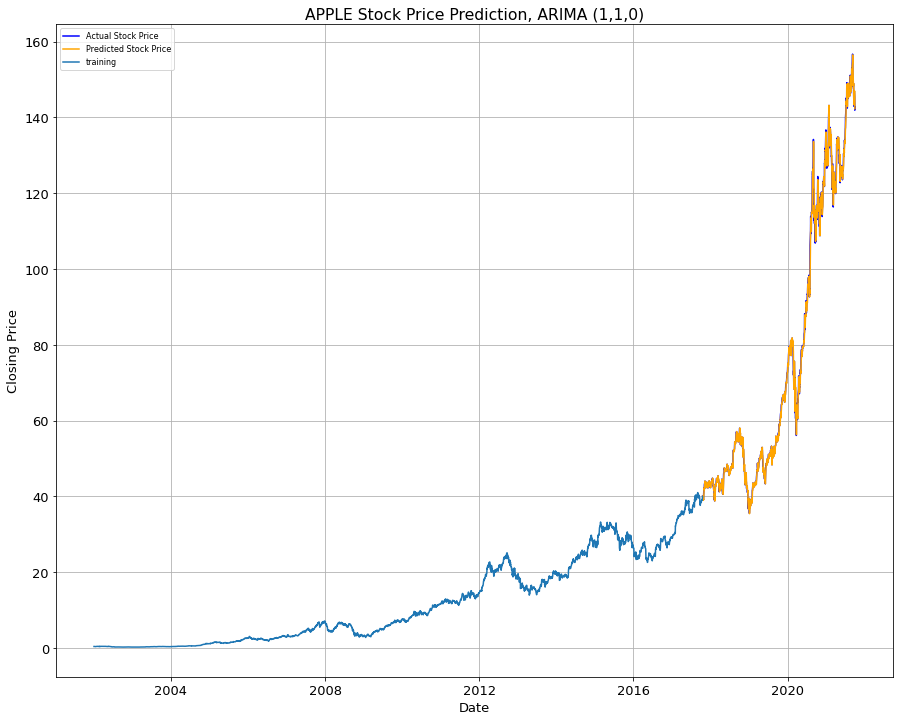

In [71]:
predict = pd.Series(predict, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(predict, color = 'orange',label='Predicted Stock Price')
plt.plot(train_data, label='training')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=0.10)
plt.title('APPLE Stock Price Prediction, ARIMA (1,1,0)')
plt.xlabel('Date')
plt.grid(True)
plt.ylabel('Closing Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy Measures:

In [72]:
# Model Performance
mse = mean_squared_error(test_data, predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, predict))
print('RMSE: '+str(rmse))

MSE: 2.9196488546518835
MAE: 1.1014190856409174
RMSE: 1.7086979998384395


In [73]:
Accuracy = pd.DataFrame({'MSE':mse, 'MAE': mae, 'RMSE':rmse}, index=[1])
Accuracy

,MSE,MAE,RMSE
1,2.919649,1.101419,1.708698


In [ ]:
# p Autoregressive -  Yt = a+ b1Yt-1 + b2Yt-2 + error 1

# when p = 2

#stock price today(yt)(Nov 8) = a + b1(price yesterday)(Nov 7) + b2(price day before )(Nov 6) + error   


# q Moving Average - Yt = a + Et + b1Et-1 + b2Et-2

#the present value of time series model are dependent on its past values and on the error of past values. the error is the difference between actual 
#values and predicted values. 

# q determines the number of past lag values error used to predict yt (determined by ACF Plot)

# Hyperparameter Tunning (p,d,q)

In [79]:
train,test = arima[:801], arima[801:]

In [177]:
train

Date
2018-01-02     43.064999
2018-01-03     43.057499
2018-01-04     43.257500
2018-01-05     43.750000
2018-01-08     43.587502
                 ...    
2021-03-03    122.059998
2021-03-04    120.129997
2021-03-05    121.419998
2021-03-08    116.360001
2021-03-09    121.089996
Name: Close, Length: 801, dtype: float64

In [80]:
test

,AAPL
Date,
2021-03-10,121.03
2021-03-11,123.99
2021-03-12,125.57
2021-03-15,124.76
2021-03-16,120.53
...,...
2021-09-23,146.83
2021-09-24,146.92
2021-09-27,145.37


In [81]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [83]:
p_values = range(0, 8)
d_values = range(0, 1) #this is the range for the values
q_values = range(0, 0) #this is the range for the values

In [84]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            train,test = arima[:754], arima[754:]
            predictions = list()
            for i in range(len(test)):
                try:
                    model = ARIMA(train,order)
                    model_fit = model.fit(disp=0)
                    pred_y = model_fit.forecast()[0]
                    predictions.append(pred_y)
                    error = mean_squared_error(test, predictions)
                    print('Best ARIMA%s , MSE = %.2f' % (order, error))
                except:
                    continue
          

Best ARIMA(0, 0, 0) , MSE = 4949.47
Best ARIMA(0, 0, 1) , MSE = 1527.38
Best ARIMA(0, 0, 2) , MSE = 1258.64
Best ARIMA(1, 0, 0) , MSE = 133.24
Best ARIMA(2, 0, 0) , MSE = 128.05
